In [1]:
%load_ext jupyter_black
import torch
import torch.optim as optim
import torch.nn as nn
from optimizers.lrmsprop import LRMSprop
from optimizers.ladam import LAdam
from optimizers.ladadelta import LAdadelta
from optimizers.lsgd import APLSGD
from optimizers.ladagrad import LAdagrad
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
from training.train import train, plot_langevin_loss
from diffusion.deephedging import DeepHedging
from scheduler import PiecewiseConstantScheduler
import os

plt.style.use(["science", "no-latex", "grid"])

seed = 42
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In this problem, we attempt to replicate a $\mathcal F_T\text{-measurable}$ payoff $Z$ defined on some portfolio $S_t\in\mathbb R^{d_1}$. The control $u_t\in\mathbb R^{d_1}$ represents the amount held at time $t$ of each asset. The objective is :
$$ J(u, w) := \mathbb E\left[w + l\left(Z - \sum_{k=0}^{N-1} \left\langle u_{t_k}, S_{t_{k+1}} - S_{t_k}\right\rangle + \sum_{k=0}^{N-1} \left\langle c_{t_r}S_{t_k}, \left|u_{t_k} - u_{t_{k-1}}\right|\right\rangle - w \right)\right]$$

Where $l: \mathbb R\to \mathbb R$ is a continuous, non-decreasing convex function. In our experiments we will consider the loss function associated with the value-at-risk i.e: $l: x\mapsto (1-\alpha)^{-1}\max(x, 0)$. We will also work in the case where $d_1$ is even, such that for $d'_1 = d_1 / 2$ the assets $(S_t^{1, i})_{1\leq i \leq d'_1} = (S_t^i)_{1\leq i \leq d'_1}$ follow $d'_1$ independant Heston dynamics, and 
$(S_t^{2, i})_{1\leq i \leq d'_1} = (S_t^i)_{d'_1 +1\leq i \leq d_1}$ are the corresponding variance swaps, i.e:
$$\left\{\begin{align}
    &dS_t^{1, i} = \sqrt{V_t^i} S_t^{1, i} \,dB^i_t\;,\;\; S_0^{1,i} = s_0^i\\
    & dV_t^i = a^i(b^i - V_t^i)dt + \eta^i\sqrt{V_t^i}\,dW^i_t\;,\;\;V_0^i = v_0^i\\
    & d\left\langle B^i, W^i\right\rangle_t = \rho^i
\end{align} \right.$$
and :
$$\begin{align}
    &S_t^{2, i} := \mathbb E\left[\int_0^T V_s^i\,ds\Big | \mathcal F_t\right] = \int_0^t V_s^i\,ds + L^i(t, V_t^i) \\
    & L^i(t, v) := \frac{v - b^i}{a^i}\left(1 - e^{- a^i(T-t)}\right) + b^i(T-t)
\end{align}$$
The payoff is chosen to be call options over the tradable assets $S^1$ i.e: $Z = \sum_{i=1} ^{d'_1} \left(S_T^{1, i} - K^i\right)_+$.
For the parameters:
$$\begin{align}
& d'_1 = 5, \; T=1, \; a=1_{\mathbb R^5}, \;b=0.04 \times 1_{\mathbb R^5}, \; \eta = 2\times 1_{\mathbb R^5}, \; \rho = -0.7 \times 1_{\mathbb R^5}, \; \alpha = 0.9, \\
&s_0 = K = 1_{\mathbb R^5}, \; v_0 = 0.1 \times 1_{\mathbb R^5}, \; c_{t_r} = 5e-4\times 1_{\mathbb R^5}.
\end{align}$$

In [2]:
train_batch = 512
test_batch = 512
train_size = 5
test_size = 25

### Single control:

In [3]:
def test_diag_single_ctrl(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = DeepHedging(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
        vanilla_optim = optim(ocp.control.parameters(), lr=lr, **optim_kwargs)
        scheduler = PiecewiseConstantScheduler(
            vanilla_optim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        scheduler_w = PiecewiseConstantScheduler(
            optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            [vanilla_optim, optim_w],
            [scheduler, scheduler_w],
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=name,
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = DeepHedging(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=False)
        optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
        loptim = langevin_optim(ocp.control.parameters(), lr=lr, sigma=sigma[i])
        scheduler = PiecewiseConstantScheduler(
            loptim, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        scheduler_w = PiecewiseConstantScheduler(
            optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        train_loss, test_loss, test_ci = train(
            ocp,
            [loptim, optim_w],
            [scheduler, scheduler_w],
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            marker="o",
            mec="k",
            ms=3,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

        axs[i].set_ylim((0, 1.2))

    plt.show()
    plt.close()

    return fig

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 5
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    dim=dim,
    ell=ell,
    a=torch.ones(dim).to(device),
    b=0.04 * torch.ones(dim).to(device),
    sigma=2.0 * torch.ones(dim).to(device),
    rho=-0.7 * torch.ones(dim).to(device),
    K=s0 * torch.ones(dim).to(device),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim).to(device),
    V_0=v0 * torch.ones(dim).to(device),
    device=device,
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.128, test=0.122: 100%|██████████| 100/100 [00:27<00:00,  3.66it/s]
Deep hedging: Epoch 99, L-Adam, lr=0.000, sigma=0.000, train=0.357, test=0.341: 100%|██████████| 100/100 [00:27<00:00,  3.65it/s]
Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.312, test=0.306: 100%|██████████| 100/100 [00:45<00:00,  2.19it/s]
Deep hedging: Epoch 99, L-Adam, lr=0.000, sigma=0.000, train=0.181, test=0.159: 100%|██████████| 100/100 [00:49<00:00,  2.03it/s]
Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.332, test=0.342: 100%|██████████| 100/100 [01:37<00:00,  1.02it/s]
Deep hedging: Epoch 99, L-Adam, lr=0.000, sigma=0.000, train=0.200, test=0.208: 100%|██████████| 100/100 [01:51<00:00,  1.12s/it]


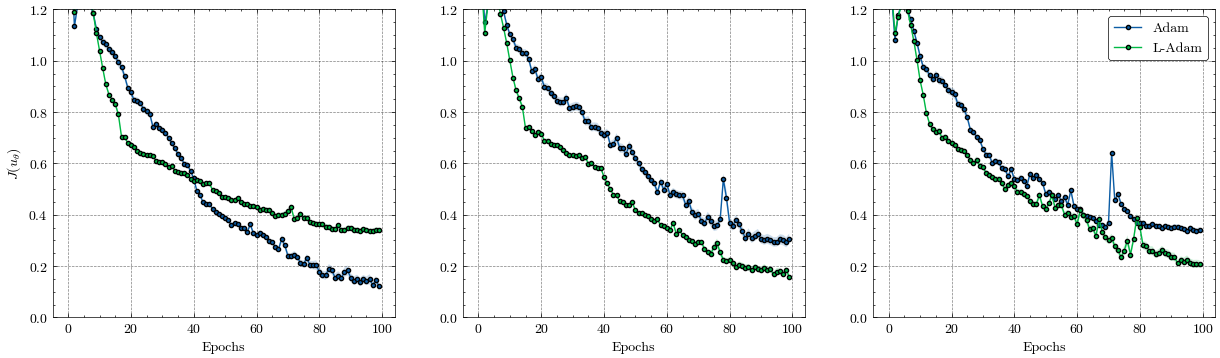

In [5]:
adam_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    100,
    80,
)

Deep hedging: Epoch 99, Adagrad, lr=0.001, sigma=0.000, train=0.578, test=0.560: 100%|██████████| 100/100 [00:34<00:00,  2.89it/s]
Deep hedging: Epoch 99, L-Adagrad, lr=0.001, sigma=0.000, train=0.511, test=0.520: 100%|██████████| 100/100 [00:37<00:00,  2.68it/s]
Deep hedging: Epoch 99, Adagrad, lr=0.001, sigma=0.000, train=0.628, test=0.615: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]
Deep hedging: Epoch 99, L-Adagrad, lr=0.001, sigma=0.000, train=0.448, test=0.453: 100%|██████████| 100/100 [00:56<00:00,  1.76it/s]
Deep hedging: Epoch 99, Adagrad, lr=0.001, sigma=0.000, train=0.562, test=0.574: 100%|██████████| 100/100 [01:59<00:00,  1.19s/it]
Deep hedging: Epoch 99, L-Adagrad, lr=0.001, sigma=0.000, train=0.469, test=0.470: 100%|██████████| 100/100 [02:00<00:00,  1.20s/it]


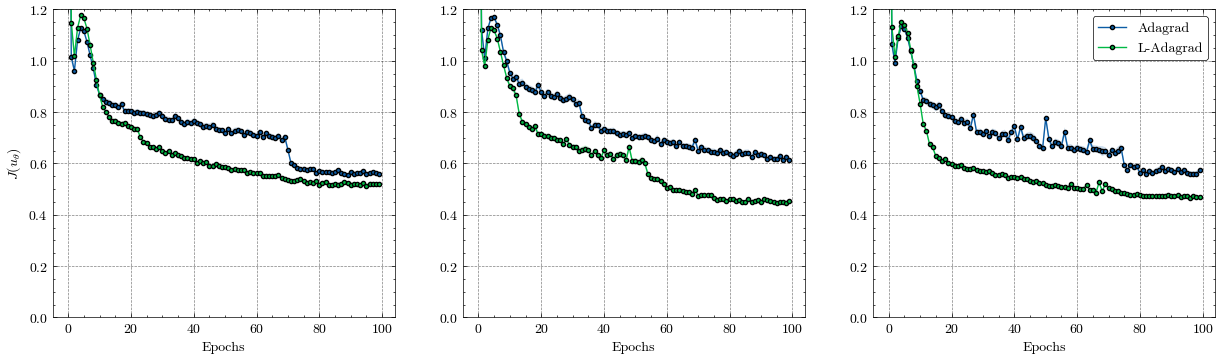

In [6]:
adagrad_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adagrad,
    LAdagrad,
    "Adagrad",
    7e-3,
    7e-4,
    [1e-5, 1e-5, 1e-5],
    100,
    80,
)

Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=0.381, test=0.382: 100%|██████████| 100/100 [00:33<00:00,  2.97it/s]
Deep hedging: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=0.290, test=0.275: 100%|██████████| 100/100 [00:36<00:00,  2.71it/s]
Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=0.438, test=0.437: 100%|██████████| 100/100 [00:54<00:00,  1.85it/s]
Deep hedging: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=0.196, test=0.175: 100%|██████████| 100/100 [00:55<00:00,  1.81it/s]
Deep hedging: Epoch 99, Adadelta, lr=0.050, sigma=0.000, train=0.424, test=0.419: 100%|██████████| 100/100 [01:53<00:00,  1.13s/it]
Deep hedging: Epoch 99, L-Adadelta, lr=0.050, sigma=0.000, train=0.273, test=0.247: 100%|██████████| 100/100 [01:58<00:00,  1.19s/it]


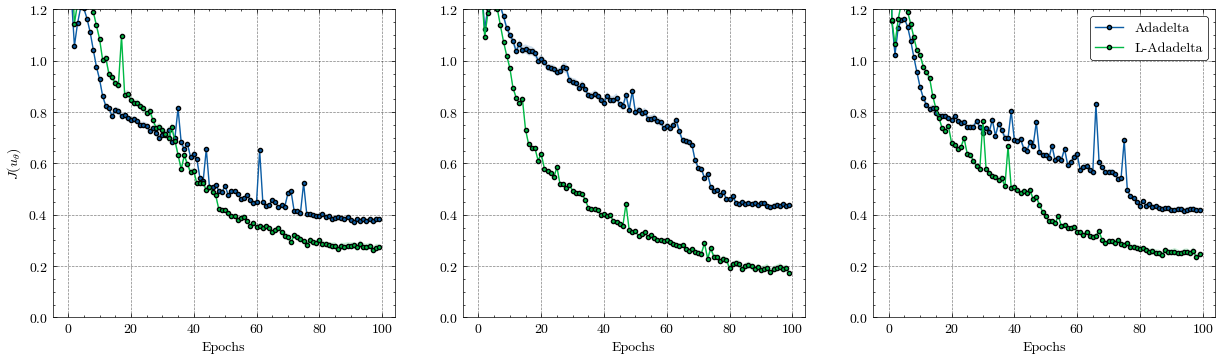

In [7]:
adadelta_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    100,
    80,
    rho=0.95,
)

Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=0.307, test=0.313: 100%|██████████| 100/100 [00:45<00:00,  2.22it/s]
Deep hedging: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=0.261, test=0.242: 100%|██████████| 100/100 [00:45<00:00,  2.18it/s]
Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=0.410, test=0.407: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]
Deep hedging: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=0.216, test=0.201: 100%|██████████| 100/100 [01:15<00:00,  1.32it/s]
Deep hedging: Epoch 99, RMSprop, lr=0.000, sigma=0.000, train=0.562, test=0.553: 100%|██████████| 100/100 [02:29<00:00,  1.50s/it]
Deep hedging: Epoch 99, L-RMSprop, lr=0.000, sigma=0.000, train=0.271, test=0.274: 100%|██████████| 100/100 [02:30<00:00,  1.51s/it]


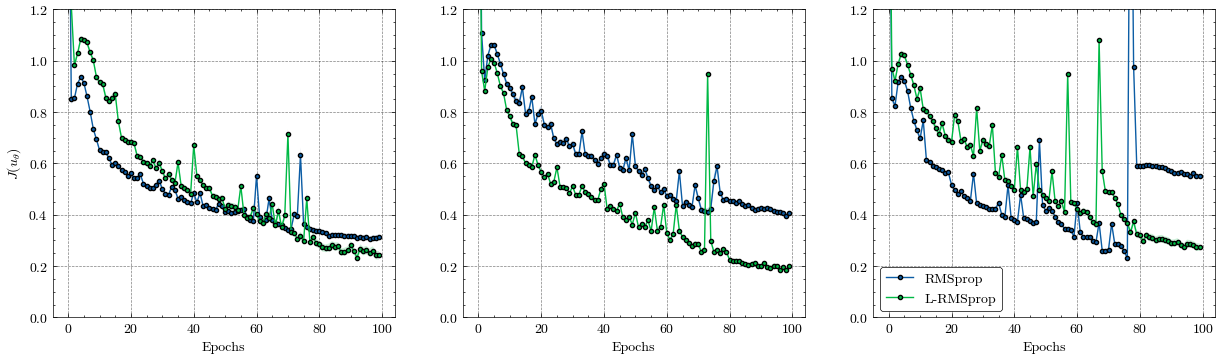

In [8]:
rmsprop_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    100,
    80,
)

Deep hedging: Epoch 99, SGD, lr=0.003, sigma=0.000, train=0.704, test=0.717: 100%|██████████| 100/100 [00:42<00:00,  2.35it/s]
Deep hedging: Epoch 99, L-SGD, lr=0.003, sigma=0.000, train=1.212, test=1.226: 100%|██████████| 100/100 [00:41<00:00,  2.41it/s]
Deep hedging: Epoch 99, SGD, lr=0.003, sigma=0.000, train=0.741, test=0.744: 100%|██████████| 100/100 [01:08<00:00,  1.46it/s]
Deep hedging: Epoch 99, L-SGD, lr=0.003, sigma=0.000, train=nan, test=nan: 100%|██████████| 100/100 [01:06<00:00,  1.51it/s]   
Deep hedging: Epoch 99, SGD, lr=0.003, sigma=0.000, train=0.475, test=0.491: 100%|██████████| 100/100 [02:09<00:00,  1.30s/it]
Deep hedging: Epoch 99, L-SGD, lr=0.003, sigma=0.000, train=1.096, test=1.110: 100%|██████████| 100/100 [02:13<00:00,  1.34s/it]


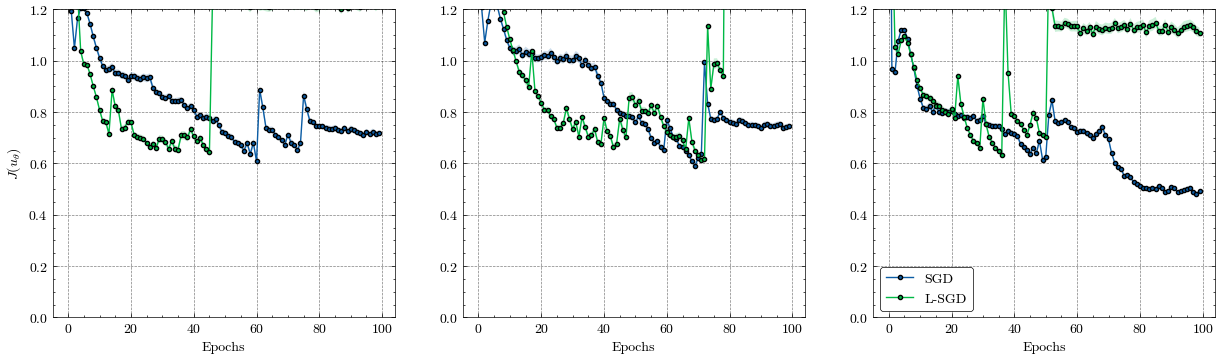

In [9]:
sgd_single_ctrl = test_diag_single_ctrl(
    model_config,
    [30, 50, 100],
    control_config,
    torch.optim.SGD,
    APLSGD,
    "SGD",
    3e-2,
    3e-3,
    [5e-5, 5e-5, 5e-5],
    100,
    80,
    momentum=0.9,
)

In [10]:
if os.path.isdir("graphs/deephedging"):
    adam_single_ctrl.savefig("graphs/deephedging/adam_single_ctrl.pdf")
    adadelta_single_ctrl.savefig("graphs/deephedging/adadelta_single_ctrl.pdf")
    rmsprop_single_ctrl.savefig("graphs/deephedging/rmsprop_single_ctrl.pdf")
    sgd_single_ctrl.savefig("graphs/deephedging/sgd_single_ctrl.pdf")
    adagrad_single_ctrl.savefig("graphs/deephedging/adagrad_single_ctrl.pdf")

### Multiple controls:

In [11]:
def test_diag_multiple_ctrls(
    model_config,
    N_euler,
    control_config,
    optim,
    langevin_optim,
    name,
    lr,
    target_lr,
    sigma,
    ll,
    epochs,
    total_iters,
    **optim_kwargs,
):
    fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

    for i, N in enumerate(N_euler):
        # Vanilla algo
        ocp = DeepHedging(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=True)
        optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
        vanilla_optim = [
            optim(control.parameters(), lr=lr, **optim_kwargs)
            for control in ocp.control
        ]
        scheduler_w = PiecewiseConstantScheduler(
            optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        scheduler = [
            PiecewiseConstantScheduler(
                optimizer, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            for optimizer in vanilla_optim
        ]
        train_loss, test_loss, test_ci = train(
            ocp,
            [optim_w, *vanilla_optim],
            [scheduler_w, *scheduler],
            name,
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(np.arange(len(test_loss)), test_loss, label=name)
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Langevin algo
        ocp = DeepHedging(**model_config, N_euler=N)
        ocp.set_control(control_config, multiple_controls=True)
        optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
        loptim = [
            langevin_optim(control.parameters(), lr=lr, sigma=sigma[i])
            for control in ocp.control
        ]
        scheduler_w = PiecewiseConstantScheduler(
            optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
        )
        scheduler = [
            PiecewiseConstantScheduler(
                optimizer, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            for optimizer in loptim
        ]
        train_loss, test_loss, test_ci = train(
            ocp,
            [optim_w, *loptim],
            [scheduler_w, *scheduler],
            f"L-{name}",
            epochs,
            train_size,
            test_size,
            train_batch,
            test_batch,
        )
        axs[i].plot(
            np.arange(len(test_loss)),
            test_loss,
            label=f"L-{name}",
        )
        axs[i].fill_between(
            np.arange(len(test_loss)),
            np.array(test_loss) - np.array(test_ci),
            np.array(test_loss) + np.array(test_ci),
            alpha=0.2,
        )

        # Layer Langevin algo
        for ll_rate in ll:
            ocp = DeepHedging(**model_config, N_euler=N)
            ocp.set_control(control_config, multiple_controls=True)
            optim_w = torch.optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
            scheduler_w = PiecewiseConstantScheduler(
                optim_w, target_lr=target_lr, target_sigma=0, total_iters=total_iters
            )
            lloptim = []
            scheduler = []
            for j, control in enumerate(ocp.control):
                if 100 * j / len(ocp.control) <= ll_rate:
                    lloptim.append(
                        langevin_optim(control.parameters(), lr=lr, sigma=sigma[i])
                    )
                else:
                    lloptim.append(optim(control.parameters(), lr=lr, **optim_kwargs))
                scheduler.append(
                    PiecewiseConstantScheduler(
                        lloptim[j],
                        target_lr=target_lr,
                        target_sigma=0,
                        total_iters=total_iters,
                    )
                )
            train_loss, test_loss, test_ci = train(
                ocp,
                [optim_w, *lloptim],
                [scheduler_w, *scheduler],
                f"LL-{name} {ll_rate}%",
                epochs,
                train_size,
                test_size,
                train_batch,
                test_batch,
            )
            axs[i].plot(
                np.arange(len(test_loss)),
                test_loss,
                label=f"LL-{name} {ll_rate}%",
            )
            axs[i].fill_between(
                np.arange(len(test_loss)),
                np.array(test_loss) - np.array(test_ci),
                np.array(test_loss) + np.array(test_ci),
                alpha=0.2,
            )

        if i == 0:
            axs[i].set_ylabel(r"$J(u_\theta)$")
        axs[i].set_xlabel("Epochs")
        if i == 2:
            legend = axs[i].legend(fancybox=True, edgecolor="k", loc=0)
            legend.get_frame().set_linewidth(0.5)

        axs[i].set_ylim((0.35, 1.2))

    plt.show()
    plt.close()

    return fig

In [12]:
model_config = dict(
    T=1.0,
    dim=dim,
    ell=ell,
    a=torch.ones(dim).to(device),
    b=0.04 * torch.ones(dim).to(device),
    sigma=2.0 * torch.ones(dim).to(device),
    rho=-0.7 * torch.ones(dim).to(device),
    K=s0 * torch.ones(dim).to(device),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim).to(device),
    V_0=v0 * torch.ones(dim).to(device),
    device=device,
)

control_config = dict(
    input_dim=4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)

Deep hedging: Epoch 199, Adam, lr=0.000, sigma=0.000, train=0.502, test=0.491: 100%|██████████| 200/200 [00:25<00:00,  7.99it/s]
Deep hedging: Epoch 199, L-Adam, lr=0.000, sigma=0.000, train=0.401, test=0.403: 100%|██████████| 200/200 [00:26<00:00,  7.58it/s]
Deep hedging: Epoch 199, LL-Adam 30%, lr=0.000, sigma=0.000, train=0.394, test=0.384: 100%|██████████| 200/200 [00:26<00:00,  7.68it/s]
Deep hedging: Epoch 199, LL-Adam 90%, lr=0.000, sigma=0.000, train=0.318, test=0.343: 100%|██████████| 200/200 [00:27<00:00,  7.28it/s]
Deep hedging: Epoch 199, Adam, lr=0.000, sigma=0.000, train=0.672, test=0.655: 100%|██████████| 200/200 [00:51<00:00,  3.92it/s]
Deep hedging: Epoch 199, L-Adam, lr=0.000, sigma=0.000, train=0.485, test=0.480: 100%|██████████| 200/200 [00:53<00:00,  3.76it/s]
Deep hedging: Epoch 199, LL-Adam 30%, lr=0.000, sigma=0.000, train=0.434, test=0.457: 100%|██████████| 200/200 [00:51<00:00,  3.89it/s]
Deep hedging: Epoch 199, LL-Adam 90%, lr=0.000, sigma=0.000, train=0.420

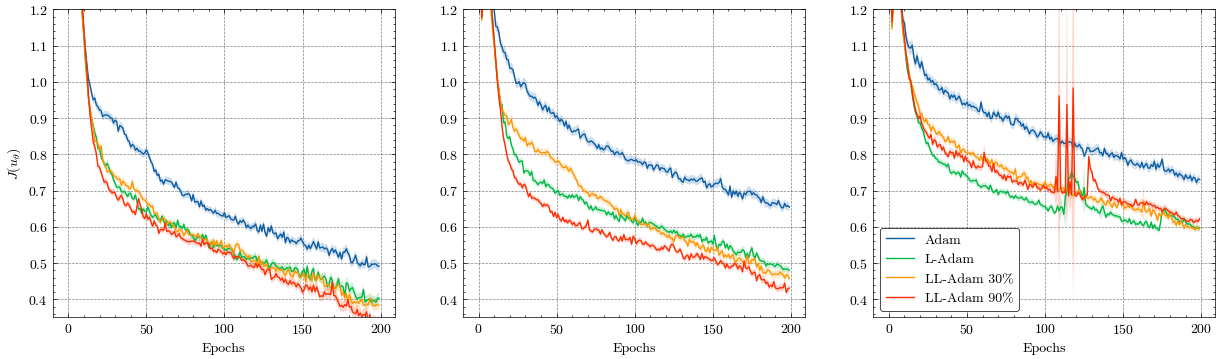

In [13]:
adam_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adam,
    LAdam,
    "Adam",
    2e-3,
    2e-4,
    [2e-4, 2e-4, 2e-4],
    [30, 90],
    200,
    180,
)

Deep hedging: Epoch 199, Adagrad, lr=0.001, sigma=0.000, train=0.883, test=0.870: 100%|██████████| 200/200 [00:29<00:00,  6.88it/s]
Deep hedging: Epoch 199, L-Adagrad, lr=0.001, sigma=0.000, train=0.596, test=0.593: 100%|██████████| 200/200 [00:33<00:00,  5.98it/s]
Deep hedging: Epoch 199, LL-Adagrad 30%, lr=0.001, sigma=0.000, train=0.665, test=0.655: 100%|██████████| 200/200 [00:39<00:00,  5.06it/s]
Deep hedging: Epoch 199, LL-Adagrad 90%, lr=0.001, sigma=0.000, train=0.606, test=0.617: 100%|██████████| 200/200 [00:38<00:00,  5.16it/s]
Deep hedging: Epoch 199, Adagrad, lr=0.001, sigma=0.000, train=0.762, test=0.748: 100%|██████████| 200/200 [01:13<00:00,  2.71it/s]
Deep hedging: Epoch 199, L-Adagrad, lr=0.001, sigma=0.000, train=0.675, test=0.666: 100%|██████████| 200/200 [01:15<00:00,  2.63it/s]
Deep hedging: Epoch 199, LL-Adagrad 30%, lr=0.001, sigma=0.000, train=0.688, test=0.690: 100%|██████████| 200/200 [00:51<00:00,  3.89it/s]
Deep hedging: Epoch 199, LL-Adagrad 90%, lr=0.001, 

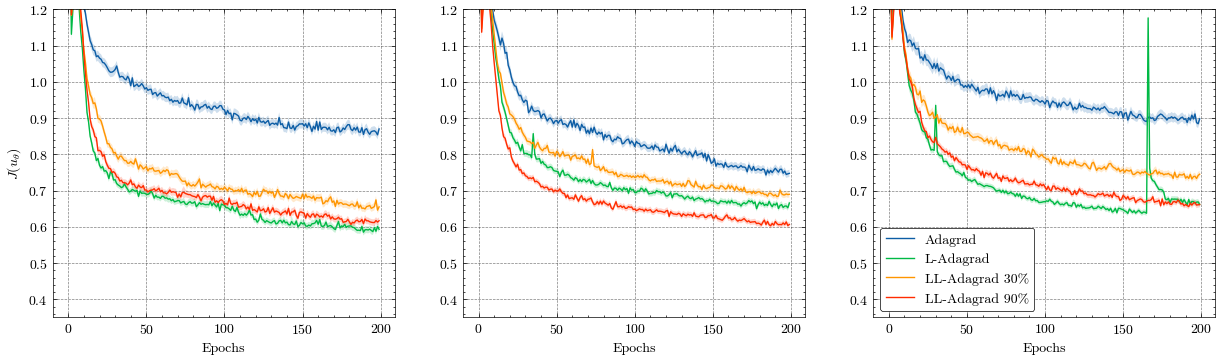

In [14]:
adagrad_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adagrad,
    LAdagrad,
    "Adagrad",
    7e-3,
    7e-4,
    [1e-5, 1e-5, 1e-5],
    [30, 90],
    200,
    180,
)

Deep hedging: Epoch 199, Adadelta, lr=0.050, sigma=0.000, train=0.800, test=0.833: 100%|██████████| 200/200 [00:24<00:00,  8.32it/s]
Deep hedging: Epoch 199, L-Adadelta, lr=0.050, sigma=0.000, train=0.278, test=0.297: 100%|██████████| 200/200 [00:27<00:00,  7.27it/s]
Deep hedging: Epoch 199, LL-Adadelta 30%, lr=0.050, sigma=0.000, train=0.526, test=0.531: 100%|██████████| 200/200 [00:25<00:00,  7.89it/s]
Deep hedging: Epoch 199, LL-Adadelta 90%, lr=0.050, sigma=0.000, train=0.343, test=0.358: 100%|██████████| 200/200 [00:27<00:00,  7.38it/s]
Deep hedging: Epoch 199, Adadelta, lr=0.050, sigma=0.000, train=0.970, test=1.004: 100%|██████████| 200/200 [00:46<00:00,  4.28it/s]
Deep hedging: Epoch 199, L-Adadelta, lr=0.050, sigma=0.000, train=0.359, test=0.365: 100%|██████████| 200/200 [00:51<00:00,  3.88it/s]
Deep hedging: Epoch 199, LL-Adadelta 30%, lr=0.050, sigma=0.000, train=0.639, test=0.645: 100%|██████████| 200/200 [00:47<00:00,  4.23it/s]
Deep hedging: Epoch 199, LL-Adadelta 90%, lr

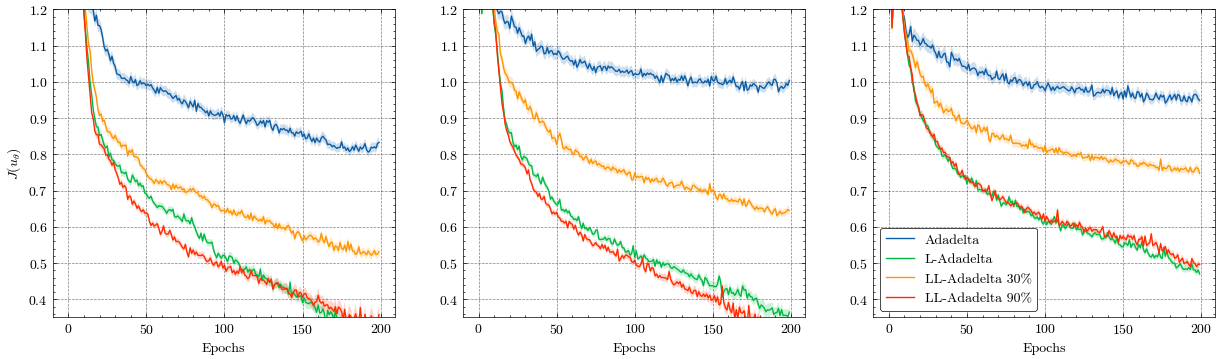

In [15]:
adadelta_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.Adadelta,
    LAdadelta,
    "Adadelta",
    5e-1,
    5e-2,
    [5e-3, 5e-3, 5e-3],
    [30, 90],
    200,
    180,
    rho=0.95,
)

Deep hedging: Epoch 199, RMSprop, lr=0.000, sigma=0.000, train=0.468, test=0.489: 100%|██████████| 200/200 [00:31<00:00,  6.38it/s]
Deep hedging: Epoch 199, L-RMSprop, lr=0.000, sigma=0.000, train=0.538, test=0.563: 100%|██████████| 200/200 [00:37<00:00,  5.40it/s] 
Deep hedging: Epoch 199, LL-RMSprop 30%, lr=0.000, sigma=0.000, train=0.441, test=0.421: 100%|██████████| 200/200 [00:32<00:00,  6.24it/s]
Deep hedging: Epoch 199, LL-RMSprop 90%, lr=0.000, sigma=0.000, train=0.413, test=0.437: 100%|██████████| 200/200 [00:32<00:00,  6.25it/s]
Deep hedging: Epoch 199, RMSprop, lr=0.000, sigma=0.000, train=0.537, test=0.541: 100%|██████████| 200/200 [00:56<00:00,  3.53it/s]
Deep hedging: Epoch 199, L-RMSprop, lr=0.000, sigma=0.000, train=0.565, test=0.587: 100%|██████████| 200/200 [00:57<00:00,  3.51it/s]
Deep hedging: Epoch 199, LL-RMSprop 30%, lr=0.000, sigma=0.000, train=0.509, test=0.486: 100%|██████████| 200/200 [00:51<00:00,  3.86it/s]
Deep hedging: Epoch 199, LL-RMSprop 90%, lr=0.000,

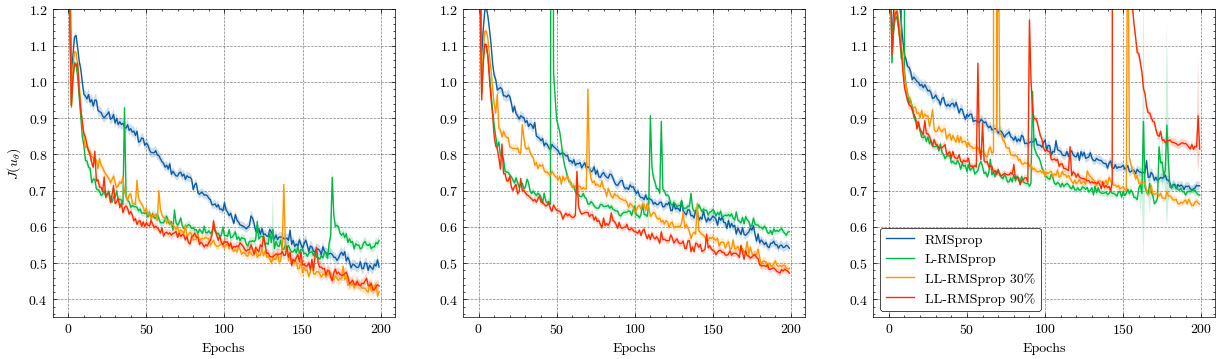

In [16]:
rmsprop_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.RMSprop,
    LRMSprop,
    "RMSprop",
    2e-3,
    2e-4,
    [2e-3, 2e-3, 2e-3],
    [30, 90],
    200,
    180,
)

Deep hedging: Epoch 199, SGD, lr=0.005, sigma=0.000, train=0.748, test=0.753: 100%|██████████| 200/200 [00:30<00:00,  6.60it/s]
Deep hedging: Epoch 199, L-SGD, lr=0.005, sigma=0.000, train=0.676, test=0.673: 100%|██████████| 200/200 [00:32<00:00,  6.16it/s]
Deep hedging: Epoch 199, LL-SGD 30%, lr=0.005, sigma=0.000, train=0.752, test=0.743: 100%|██████████| 200/200 [00:29<00:00,  6.67it/s]
Deep hedging: Epoch 199, LL-SGD 90%, lr=0.005, sigma=0.000, train=0.701, test=0.705: 100%|██████████| 200/200 [00:30<00:00,  6.51it/s]
Deep hedging: Epoch 199, SGD, lr=0.005, sigma=0.000, train=0.852, test=0.858: 100%|██████████| 200/200 [00:55<00:00,  3.59it/s]
Deep hedging: Epoch 199, L-SGD, lr=0.005, sigma=0.000, train=0.809, test=0.818: 100%|██████████| 200/200 [00:59<00:00,  3.35it/s]
Deep hedging: Epoch 199, LL-SGD 30%, lr=0.005, sigma=0.000, train=0.866, test=0.846: 100%|██████████| 200/200 [12:27<00:00,  3.74s/it]   
Deep hedging: Epoch 199, LL-SGD 90%, lr=0.005, sigma=0.000, train=0.856, tes

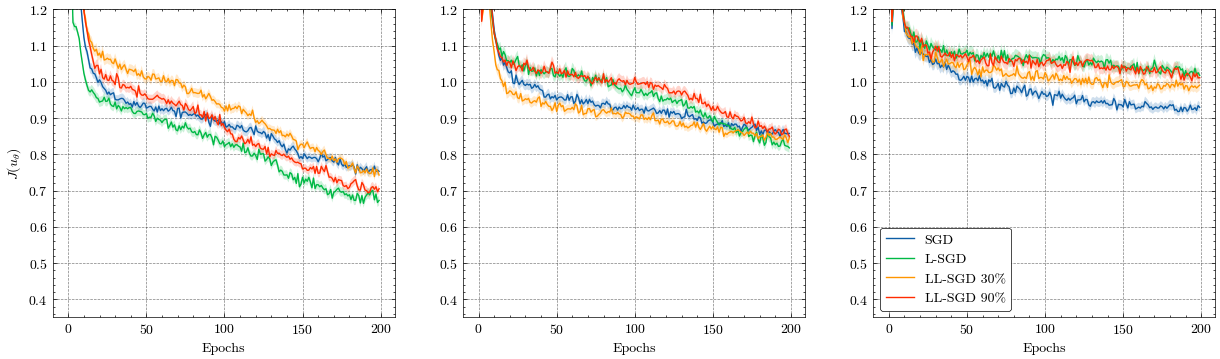

In [17]:
sgd_multiple_ctrl = test_diag_multiple_ctrls(
    model_config,
    [10, 20, 40],
    control_config,
    optim.SGD,
    APLSGD,
    "SGD",
    5e-2,
    5e-3,
    [2e-3, 2e-3, 2e-3],
    [30, 90],
    200,
    180,
    momentum=0.9,
)

In [18]:
# if os.path.isdir("graphs/deephedging"):
#     adam_multiple_ctrl.savefig("graphs/deephedging/adam_multiple_ctrl.pdf")
#     adadelta_multiple_ctrl.savefig("graphs/deephedging/adadelta_multiple_ctrl.pdf")
#     rmsprop_multiple_ctrl.savefig("graphs/deephedging/rmsprop_multiple_ctrl.pdf")
#     sgd_multiple_ctrl.savefig("graphs/deephedging/sgd_multiple_ctrl.pdf")
#     adagrad_multiple_ctrl.savefig("graphs/deephedging/adagrad_multiple_ctrl.pdf")

### Sample trajectory:

In [46]:
alpha = 0.9
ell = lambda x: nn.functional.relu(x) / (1.0 - alpha)
dim = 1
s0 = 1.0
v0 = 0.1


model_config = dict(
    T=1.0,
    N_euler=50,
    dim=dim,
    ell=ell,
    a=torch.ones(dim),
    b=0.04 * torch.ones(dim),
    sigma=2.0 * torch.ones(dim),
    rho=-0.7 * torch.ones(dim),
    K=s0 * torch.ones(dim),
    T_COST=5e-4,
    S_0=s0 * torch.ones(dim),
    V_0=v0 * torch.ones(dim),
)

control_config = dict(
    input_dim=1 + 4 * dim,
    output_dim=2 * dim,
    hidden_dim=32,
    depth=2,
    activation=nn.ReLU(),
    out_transform=nn.ReLU(),
)
epochs = 100

In [52]:
ocp = DeepHedging(**model_config)
ocp.set_control(control_config, multiple_controls=False)
optim_w = optim.SGD(ocp.w.parameters(), lr=2e-3, momentum=0.9)
adam_control = optim.Adam(ocp.control.parameters(), lr=2e-3)
adam = [optim_w, adam_control]

scheduler_w = PiecewiseConstantScheduler(
    optim_w, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler_control = PiecewiseConstantScheduler(
    adam_control, target_lr=2e-4, target_sigma=0, total_iters=80
)
scheduler = [scheduler_w, scheduler_control]

In [53]:
train_loss_adam, test_loss_adam, test_ci_adam = train(
    ocp,
    adam,
    scheduler,
    "Adam",
    epochs,
    train_size,
    test_size,
    train_batch,
    test_batch,
    False,
)

Deep hedging: Epoch 99, Adam, lr=0.000, sigma=0.000, train=0.101, test=0.100: 100%|██████████| 100/100 [00:25<00:00,  3.98it/s]


In [54]:
S1, S2, V, u = ocp.sample_traj(1)

Sampling trajectories: 100%|██████████| 50/50 [00:00<00:00, 3971.05it/s]


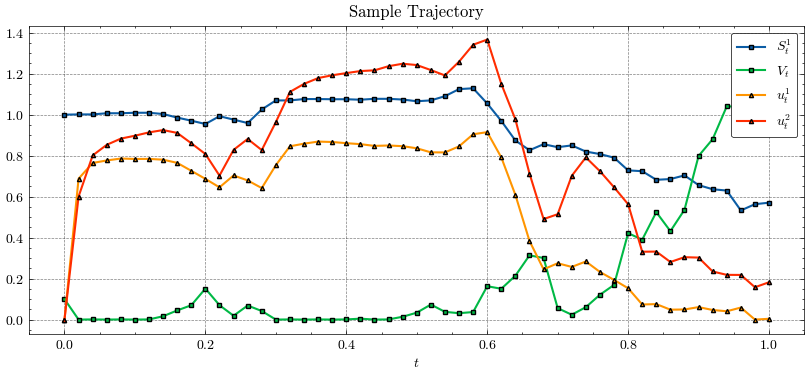

In [55]:
fig = plt.figure(figsize=(10, 4))

t = model_config["T"] / model_config["N_euler"] * np.arange(model_config["N_euler"] + 1)
plt.plot(
    t,
    S1.flatten().detach().numpy(),
    label=r"$S_t^1$",
    marker="s",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t, V.flatten().detach().numpy(), label=r"$V_t$", marker="s", mec="k", ms=3, lw=1.5
)
plt.plot(
    t,
    u[:, :, 0].flatten().detach().numpy(),
    label=r"$u_t^1$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)
plt.plot(
    t,
    u[:, :, 1].flatten().detach().numpy(),
    label=r"$u_t^2$",
    marker="^",
    mec="k",
    ms=3,
    lw=1.5,
)

legend = plt.legend(fancybox=True, edgecolor="black", loc=0)
legend.get_frame().set_linewidth(0.5)
plt.title("Sample Trajectory")
plt.xlabel(r"$t$")
# fig.savefig("graphs/deephedging/Sample_traj_hedging_N50.pdf")
plt.show()
plt.close()